## Daily Climate time series data ##

In this notebook we solve sequential task using DL. data set also available on Kaggle: https://www.kaggle.com/sumanthvrao/daily-climate-time-series-data#DailyDelhiClimateTrain.csv


**Context:**

The Dataset is fully dedicated for the developers who want to train the model on Weather Forecasting for Indian climate. This dataset provides data from 1st January 2013 to 24th April 2017 in the city of Delhi, India. The 4 parameters here are meantemp, humidity, wind_speed, meanpressure.

The dataset is divided into a training set and a test set. The training set and validation set each consist of 1576 records total.

There are this type of data: data; meantemp; humidity; wind_speed.

**Goal:**

To build a sequential model for weather prediction.

## 1. Importing the data



**1.1. Preparing environment and importing libraries**

In [1]:
try:
    %tensorflow_version 2.x
except Exception:
    pass

TensorFlow 2.x selected.


In [0]:
SETUP = True

In [3]:
if SETUP:
    !pip install -q -U toai
    !pip install -q -U nb_black
    !pip install -q -U tensorflow-datasets
    !pip install -q -U --no-deps tensorflow-addons~=0.6
    print(__import__("toai").__version__)
    print(__import__("tensorflow").__version__)

     |████████████████████████████████| 153kB 25.5MB/s 
     |████████████████████████████████| 81kB 12.6MB/s 
     |████████████████████████████████| 296kB 68.0MB/s 
     |████████████████████████████████| 61kB 10.0MB/s 
     |████████████████████████████████| 122kB 60.5MB/s 
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.7.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement requests~=2.21.0, but you'll have requests 2.22.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 102kB 5.8MB/s 
     |████████████████████████████████| 645kB 29.4MB/s 
     |████████████████████████████████| 737kB 51.2MB/s 
     |████████████████████████████████| 1.8MB 8.8MB/s 
0.2.1
2.0.0


In [0]:
# %load_ext nb_black

In [0]:
import os

# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [6]:
from toai.imports import *
from toai.data import DataBundle, DataParams, DataContainer
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
import tensorflow_datasets as tfds

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/toai/imports.py:70: UserWarning: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
  warnings.warn(str(error))


In [0]:
import matplotlib
import matplotlib.pyplot as plt # to run these lines few times

%matplotlib inline

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## **2. Data preparation, feature engineering, exploration and preprocessing**

In [0]:
DATA_DIR = Path("drive/My Drive/Kiti/AI/sprint11_5/climate")
DATA_DIR.mkdir(parents=True, exist_ok=True)
TEMP_DIR = Path('drive/My Drive/Kiti/AI/sprint11_5/temp/climate')
TEMP_DIR.mkdir(parents=True, exist_ok=True)

In [10]:
def setup_kaggle():
    x = !ls kaggle.json
    assert x == ['kaggle.json'], 'Upload kaggle.json'
    !mkdir /root/.kaggle
    !mv kaggle.json /root/.kaggle
    !chmod 600 /root/.kaggle/kaggle.json

setup_kaggle()

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [0]:
import kaggle

In [0]:
if SETUP:
    kaggle.api.authenticate()
    kaggle.api.dataset_download_files(
        dataset="sumanthvrao/daily-climate-time-series-data",
        path=str(DATA_DIR),
        unzip=True,
    )

In [0]:
# !kaggle datasets download -q --unzip sumanthvrao/daily-climate-time-series-data -p {str(DATA_DIR)}

In [0]:
data_train = pd.read_csv(DATA_DIR / "DailyDelhiClimateTrain.csv")

In [0]:
data_test = pd.read_csv(DATA_DIR / "DailyDelhiClimateTest.csv")

In [16]:
data_train.head().T

,0,1,2,3,4
date,2013-01-01,2013-01-02,2013-01-03,2013-01-04,2013-01-05
meantemp,10,7.4,7.16667,8.66667,6
humidity,84.5,92,87,71.3333,86.8333
wind_speed,0,2.98,4.63333,1.23333,3.7
meanpressure,1015.67,1017.8,1018.67,1017.17,1016.5


In [17]:
data_test.head().T

,0,1,2,3,4
date,2017-01-01,2017-01-02,2017-01-03,2017-01-04,2017-01-05
meantemp,15.913,18.5,17.1111,18.7,18.3889
humidity,85.8696,77.2222,81.8889,70.05,74.9444
wind_speed,2.74348,2.89444,4.01667,4.545,3.3
meanpressure,59,1018.28,1018.33,1015.7,1014.33


Concatinate the data from Train and test datasets to have one source

In [0]:
data = pd.concat([data_train, data_test], ignore_index=True, sort=False)

In [19]:
data.shape

(1576, 5)

In [20]:
data.head().T

,0,1,2,3,4
date,2013-01-01,2013-01-02,2013-01-03,2013-01-04,2013-01-05
meantemp,10,7.4,7.16667,8.66667,6
humidity,84.5,92,87,71.3333,86.8333
wind_speed,0,2.98,4.63333,1.23333,3.7
meanpressure,1015.67,1017.8,1018.67,1017.17,1016.5


In [0]:
data_params = DataParams(
    target_col="meantemp",
    cont_cols=["humidity", "wind_speed", "meanpressure"],
)

In [0]:
for col in [data_params.target_col] + data_params.cont_cols:
    data[col] = pd.to_numeric(data[col], errors="coerce")

In [0]:
data.replace(0, np.nan, inplace=True)

In [0]:
data["date"] = pd.to_datetime(data["date"])

In [25]:
data.head().T

,0,1,2,3,4
date,2013-01-01 00:00:00,2013-01-02 00:00:00,2013-01-03 00:00:00,2013-01-04 00:00:00,2013-01-05 00:00:00
meantemp,10,7.4,7.16667,8.66667,6
humidity,84.5,92,87,71.3333,86.8333
wind_speed,NaN,2.98,4.63333,1.23333,3.7
meanpressure,1015.67,1017.8,1018.67,1017.17,1016.5


In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1576 entries, 0 to 1575
Data columns (total 5 columns):
date            1576 non-null datetime64[ns]
meantemp        1576 non-null float64
humidity        1576 non-null float64
wind_speed      1550 non-null float64
meanpressure    1576 non-null float64
dtypes: datetime64[ns](1), float64(4)
memory usage: 61.7 KB


In [27]:
data.describe()

,meantemp,humidity,wind_speed,meanpressure
count,1576.000000,1576.000000,1550.000000,1576.000000
mean,25.221918,60.445229,7.014991,1010.593178
std,7.345014,16.979994,4.458227,175.242704
min,6.000000,13.428571,0.462500,-3.041667
25%,18.500000,49.750000,3.712500,1001.875000
50%,27.166667,62.440476,6.479167,1009.055556
75%,31.142857,72.125000,9.275000,1015.200000
max,38.714286,100.000000,42.220000,7679.333333


In [0]:
data.fillna(method="pad", inplace=True)

In [0]:
data.fillna(method="backfill", inplace=True)

In [0]:
# import pandas_profiling

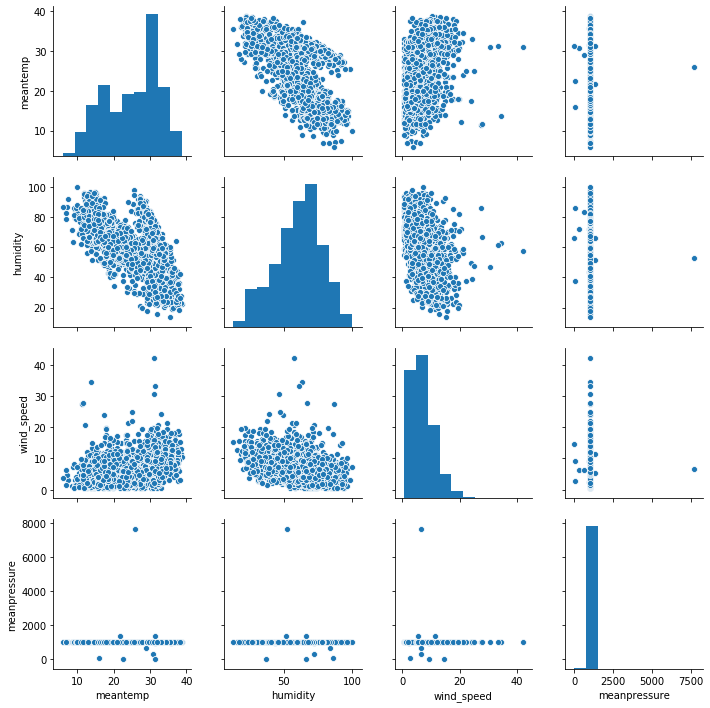

In [31]:
sns.pairplot(data)

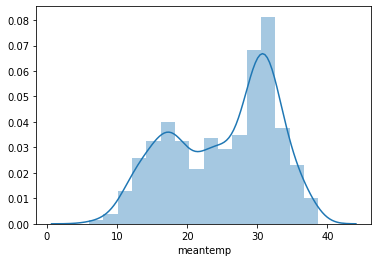

In [32]:
sns.distplot(data["meantemp"])

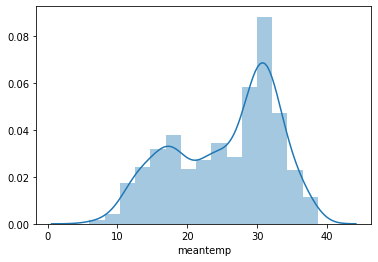

In [33]:
sns.distplot(data_train["meantemp"])

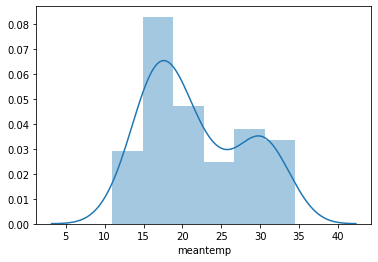

In [34]:
sns.distplot(data_test["meantemp"])

Test and Train data sets seems quite different

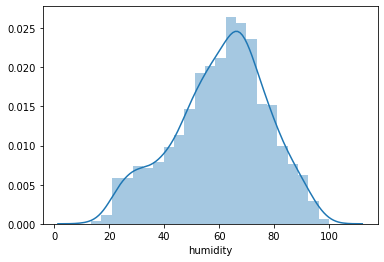

In [35]:
sns.distplot(data["humidity"])

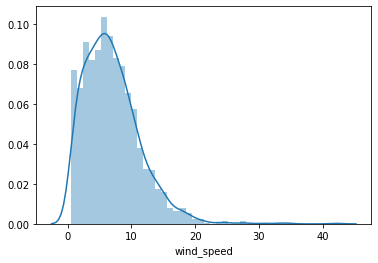

In [36]:
sns.distplot(data["wind_speed"])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f2748e6c4a8>,
      dtype=object)

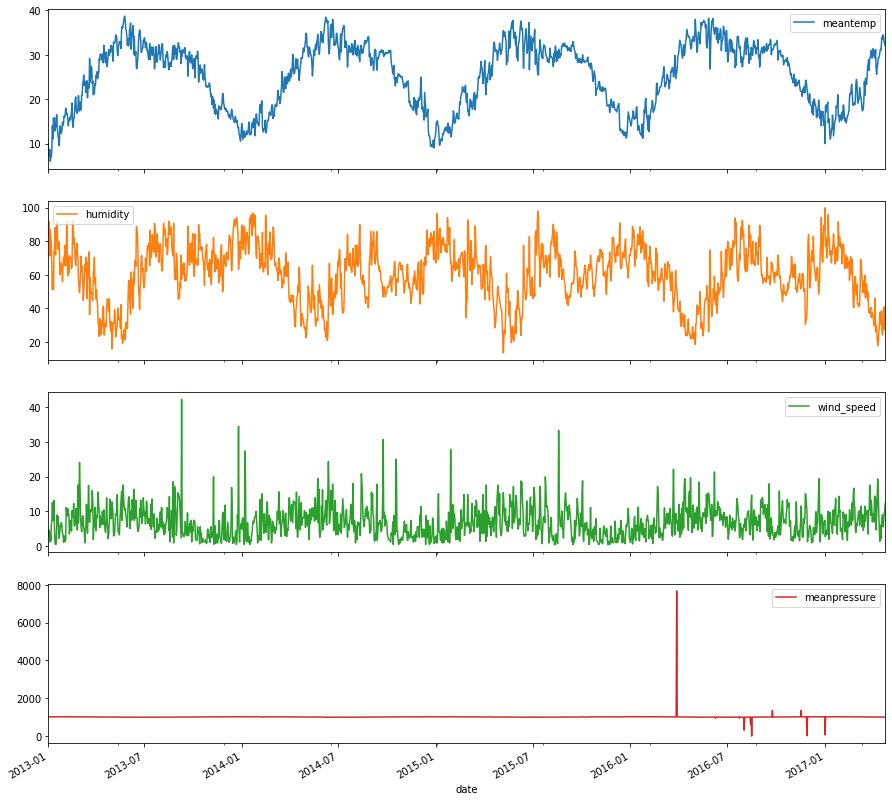

In [37]:
data.plot(x="date", subplots=True, figsize=(15, 15))

We chose as target: meantemp, because it has clear pattern

Train, val, test split

In [0]:
def split_timeseries_df(
    data: pd.DataFrame, test_size: float
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    train_data, test_data = train_test_split(data, test_size=test_size, shuffle=False)
    val_data, test_data = train_test_split(test_data, test_size=0.5, shuffle=False)
    return train_data, val_data, test_data

In [0]:
train_data, val_data, test_data = split_timeseries_df(data, 0.4)

In [40]:
[series.shape for series in (train_data, val_data, test_data)]

[(945, 5), (315, 5), (316, 5)]

In [41]:
train_data.iloc[-1], val_data.iloc[0]

(date            2015-08-03 00:00:00
 meantemp                       31.5
 humidity                     58.625
 wind_speed                    5.325
 meanpressure                1001.88
 Name: 944, dtype: object, date            2015-08-04 00:00:00
 meantemp                    29.4286
 humidity                    77.7857
 wind_speed                  4.77143
 meanpressure                1000.07
 Name: 945, dtype: object)

In [42]:
val_data.iloc[-1], test_data.iloc[0]

(date            2016-06-13 00:00:00
 meantemp                         36
 humidity                    43.3125
 wind_speed                    12.85
 meanpressure                998.188
 Name: 1259, dtype: object, date            2016-06-14 00:00:00
 meantemp                     32.625
 humidity                     55.125
 wind_speed                    11.86
 meanpressure                997.812
 Name: 1260, dtype: object)

In [0]:
def timeseries_extract_distributed_labels(
    series: np.ndarray, pred_length: int
) -> Tuple[np.ndarray, np.ndarray]:
    n_labels = series.shape[1] - pred_length
    labels = np.empty((series.shape[0], n_labels, pred_length))
    for step_ahead in range(1, pred_length + 1):
        labels[..., step_ahead - 1] = series[..., step_ahead : step_ahead + n_labels, 0]
    return series[:, :-pred_length], labels

In [0]:
series_name = "meantemp"

In [0]:
train_mean = train_data[series_name].mean()

In [0]:
train_std = train_data[series_name].std()

In [0]:
def make_standard_scaler(mean, std):
    def scaler(series):
        return (series - mean) / std

    return scaler

In [0]:
scaler = make_standard_scaler(train_mean, train_std)

In [0]:
train_data, val_data, test_data = [
    scaler(series[series_name].values).reshape(1, -1, 1)
    for series in (train_data, val_data, test_data)
]

In [0]:
prediction_length = 5

In [0]:
(train_data, train_labels), (val_data, val_labels), (test_data, test_labels) = [
    timeseries_extract_distributed_labels(series, prediction_length)
    for series in (train_data, val_data, test_data)
]

In [52]:
[series.shape for series in (train_data, val_data, test_data)]

[(1, 940, 1), (1, 310, 1), (1, 311, 1)]

In [53]:
[series.shape for series in (train_labels, val_labels, test_labels)]

[(1, 940, 5), (1, 310, 5), (1, 311, 5)]

In [54]:
train_data[0, 1:6, 0]

array([-2.3325928 , -2.36346329, -2.16501013, -2.51781574, -2.38551364])

In [55]:
train_labels[0, 0, :]

array([-2.3325928 , -2.36346329, -2.16501013, -2.51781574, -2.38551364])

In [56]:
train_data[0, -1, 0]

0.45898158825803687

In [57]:
val_data[0, :5, :]

array([[0.58183354],
       [0.60368701],
       [0.59128369],
       [0.55820817],
       [0.50859488]])

Some functions

In [0]:
def make_naive_model(mode: str = "last"):
    def predict(series: np.ndarray) -> np.ndarray:
        if mode == "mean":
            return np.mean(series, axis=1)
        return series[:, -1]

    return predict

In [0]:
class NaiveModel:
    def __init__(self, mode: str = "last"):
        self.mode = mode

    def predict(self, series: np.ndarray) -> np.ndarray:
        if self.mode == "mean":
            return np.mean(series, axis=1)
        return series[:, -1]

In [0]:
def plot_timeseries(
    series: np.ndarray,
    n_steps: int,
    y_true: Optional[float] = None,
    y_pred: Optional[float] = None,
):
    plt.plot(series, ".-")
    if y_true is not None:
        plt.plot(n_steps, y_true, "bo", markersize=8)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro", markersize=8)

In [0]:
def plot_multiple_distributed_forecasts(data, labels, predictions):
    n_steps = data.shape[1]
    ahead = labels.shape[2]
    plot_timeseries(data[0, -ahead * 5 :, 0], ahead * 5)
    plt.plot(
        np.arange(ahead * 5, ahead * 6),
        labels[0, n_steps - 1, :],
        "ro-",
        label="Actual",
        markersize=5,
    )
    plt.plot(
        np.arange(ahead * 5, ahead * 6),
        predictions[0, n_steps - 1, :],
        "go-",
        label="Forecast",
        markersize=5,
    )
    plt.legend(fontsize=14)

## **3. Building the models**

In [0]:
callbacks = [
    keras.callbacks.EarlyStopping(patience=500, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(patience=300, factor=0.3, min_lr=3e-6),
]

## 3.1. RNN

In [0]:
model_RNN = keras.models.Sequential(
    [
        keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]),
        keras.layers.SimpleRNN(32, return_sequences=True),
        keras.layers.TimeDistributed(keras.layers.Dense(prediction_length)),
    ]
)

In [0]:
model_RNN.compile(loss=keras.losses.mse, optimizer=keras.optimizers.Adam(lr=1e-3))

In [106]:
model_RNN.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, None, 32)          1088      
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 5)           165       
Total params: 3,333
Trainable params: 3,333
Non-trainable params: 0
_________________________________________________________________


In [107]:
model_RNN.fit(
    train_data,
    train_labels,
    validation_data=(val_data, val_labels),
    epochs=100,
    verbose=2,
    callbacks=callbacks,
)

Train on 1 samples, validate on 1 samples
Epoch 1/100
1/1 - 3s - loss: 1.4225 - val_loss: 1.1004
Epoch 2/100
1/1 - 1s - loss: 1.1420 - val_loss: 0.8471
Epoch 3/100
1/1 - 1s - loss: 0.8821 - val_loss: 0.6673
Epoch 4/100
1/1 - 1s - loss: 0.6956 - val_loss: 0.5769
Epoch 5/100
1/1 - 1s - loss: 0.6004 - val_loss: 0.5174
Epoch 6/100
1/1 - 1s - loss: 0.5379 - val_loss: 0.4616
Epoch 7/100
1/1 - 1s - loss: 0.4806 - val_loss: 0.4059
Epoch 8/100
1/1 - 1s - loss: 0.4244 - val_loss: 0.3533
Epoch 9/100
1/1 - 1s - loss: 0.3717 - val_loss: 0.3074
Epoch 10/100
1/1 - 1s - loss: 0.3261 - val_loss: 0.2710
Epoch 11/100
1/1 - 1s - loss: 0.2905 - val_loss: 0.2448
Epoch 12/100
1/1 - 1s - loss: 0.2653 - val_loss: 0.2273
Epoch 13/100
1/1 - 1s - loss: 0.2492 - val_loss: 0.2156
Epoch 14/100
1/1 - 1s - loss: 0.2390 - val_loss: 0.2069
Epoch 15/100
1/1 - 1s - loss: 0.2319 - val_loss: 0.1998
Epoch 16/100
1/1 - 1s - loss: 0.2262 - val_loss: 0.1941
Epoch 17/100
1/1 - 1s - loss: 0.2215 - val_loss: 0.1902
Epoch 18/100
1/

In [108]:
result_model_RNN = model_RNN.evaluate(test_data, test_labels, verbose=2)

1/1 - 0s - loss: 0.1001


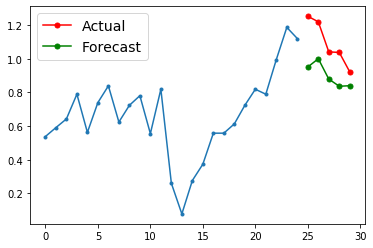

In [109]:
plot_multiple_distributed_forecasts(test_data, test_labels, model_RNN.predict(test_data))

## 3.2. LSTM

In [0]:
model_LSTM = keras.models.Sequential(
    [
        keras.layers.LSTM(256, return_sequences=True, input_shape=[None, 1]),
        keras.layers.LSTM(128, return_sequences=True),
        keras.layers.Dense(prediction_length),
    ]
)

In [0]:
model_LSTM.compile(loss=keras.losses.mse, optimizer=keras.optimizers.Adam(lr=1e-3))

In [112]:
model_LSTM.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, None, 256)         264192    
_________________________________________________________________
lstm_6 (LSTM)                (None, None, 128)         197120    
_________________________________________________________________
dense_5 (Dense)              (None, None, 5)           645       
Total params: 461,957
Trainable params: 461,957
Non-trainable params: 0
_________________________________________________________________


In [113]:
model_LSTM.fit(
    train_data,
    train_labels,
    validation_data=(val_data, val_labels),
    epochs=1000,
    verbose=2,
    callbacks=callbacks,
)

Train on 1 samples, validate on 1 samples
Epoch 1/1000
1/1 - 3s - loss: 1.0111 - val_loss: 0.7080
Epoch 2/1000
1/1 - 0s - loss: 0.7196 - val_loss: 0.4640
Epoch 3/1000
1/1 - 0s - loss: 0.4648 - val_loss: 0.2730
Epoch 4/1000
1/1 - 0s - loss: 0.2700 - val_loss: 0.2992
Epoch 5/1000
1/1 - 0s - loss: 0.3118 - val_loss: 0.2085
Epoch 6/1000
1/1 - 0s - loss: 0.2334 - val_loss: 0.1528
Epoch 7/1000
1/1 - 0s - loss: 0.1809 - val_loss: 0.1524
Epoch 8/1000
1/1 - 0s - loss: 0.1807 - val_loss: 0.1654
Epoch 9/1000
1/1 - 0s - loss: 0.1938 - val_loss: 0.1670
Epoch 10/1000
1/1 - 0s - loss: 0.1956 - val_loss: 0.1540
Epoch 11/1000
1/1 - 0s - loss: 0.1834 - val_loss: 0.1342
Epoch 12/1000
1/1 - 0s - loss: 0.1650 - val_loss: 0.1178
Epoch 13/1000
1/1 - 0s - loss: 0.1510 - val_loss: 0.1117
Epoch 14/1000
1/1 - 0s - loss: 0.1476 - val_loss: 0.1142
Epoch 15/1000
1/1 - 0s - loss: 0.1518 - val_loss: 0.1169
Epoch 16/1000
1/1 - 0s - loss: 0.1543 - val_loss: 0.1151
Epoch 17/1000
1/1 - 0s - loss: 0.1506 - val_loss: 0.112

In [114]:
result_model_LSTM = model_LSTM.evaluate(test_data, test_labels, verbose=2)

1/1 - 1s - loss: 0.1003


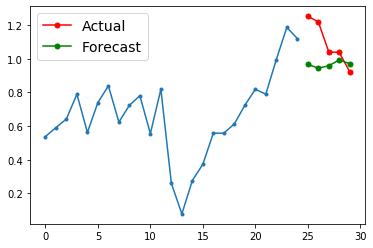

In [115]:
plot_multiple_distributed_forecasts(test_data, test_labels, model_LSTM.predict(test_data))

## 3.3. LSTM_DO - LSTM with Drop out

In [0]:
model_LSTM_DO = keras.models.Sequential(
    [
        keras.layers.LSTM(
            128, dropout=0.1, return_sequences=True, input_shape=[None, 1]
        ),
        keras.layers.LSTM(128, dropout=0.1, return_sequences=True),
        keras.layers.Dense(prediction_length),
    ]
)

In [0]:
model_LSTM_DO.compile(loss=keras.losses.mse, optimizer=keras.optimizers.Adam(lr=1e-3))

In [118]:
model_LSTM_DO.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, None, 128)         66560     
_________________________________________________________________
lstm_8 (LSTM)                (None, None, 128)         131584    
_________________________________________________________________
dense_6 (Dense)              (None, None, 5)           645       
Total params: 198,789
Trainable params: 198,789
Non-trainable params: 0
_________________________________________________________________


In [119]:
model_LSTM_DO.fit(
    train_data,
    train_labels,
    validation_data=(val_data, val_labels),
    epochs=1000,
    verbose=2,
    callbacks=callbacks,
)

Train on 1 samples, validate on 1 samples
Epoch 1/1000
1/1 - 3s - loss: 1.0213 - val_loss: 0.8355
Epoch 2/1000
1/1 - 0s - loss: 0.8566 - val_loss: 0.6828
Epoch 3/1000
1/1 - 0s - loss: 0.6913 - val_loss: 0.5260
Epoch 4/1000
1/1 - 0s - loss: 0.5294 - val_loss: 0.3741
Epoch 5/1000
1/1 - 0s - loss: 0.3713 - val_loss: 0.2733
Epoch 6/1000
1/1 - 0s - loss: 0.2663 - val_loss: 0.2628
Epoch 7/1000
1/1 - 0s - loss: 0.2654 - val_loss: 0.2528
Epoch 8/1000
1/1 - 0s - loss: 0.2747 - val_loss: 0.2152
Epoch 9/1000
1/1 - 0s - loss: 0.2484 - val_loss: 0.1780
Epoch 10/1000
1/1 - 0s - loss: 0.2112 - val_loss: 0.1579
Epoch 11/1000
1/1 - 0s - loss: 0.1925 - val_loss: 0.1552
Epoch 12/1000
1/1 - 0s - loss: 0.1908 - val_loss: 0.1615
Epoch 13/1000
1/1 - 0s - loss: 0.1936 - val_loss: 0.1669
Epoch 14/1000
1/1 - 0s - loss: 0.1951 - val_loss: 0.1661
Epoch 15/1000
1/1 - 0s - loss: 0.1938 - val_loss: 0.1577
Epoch 16/1000
1/1 - 0s - loss: 0.1896 - val_loss: 0.1444
Epoch 17/1000
1/1 - 0s - loss: 0.1800 - val_loss: 0.130

In [120]:
result_model_LSTM_DO = model_LSTM_DO.evaluate(val_data, val_labels, verbose=2)

1/1 - 1s - loss: 0.1033


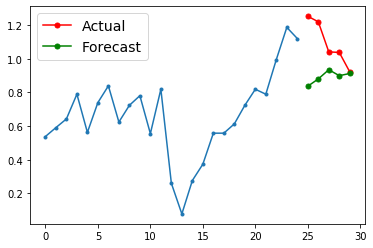

In [121]:
plot_multiple_distributed_forecasts(val_data, val_labels, model_LSTM_DO.predict(val_data))

## 3.4. 1D Convolutional model

In [0]:
model_CNN = keras.models.Sequential(
    [
        keras.layers.Conv1D(
            filters=128, kernel_size=6, padding="same", input_shape=[None, 1]
        ),
        keras.layers.Conv1D(filters=128, kernel_size=10, padding="same"),
        keras.layers.Conv1D(filters=128, kernel_size=10, padding="same"),
        keras.layers.Conv1D(filters=128, kernel_size=10, padding="same"),
        keras.layers.Conv1D(filters=128, kernel_size=10, padding="same"),
        keras.layers.Conv1D(filters=128, kernel_size=10, padding="same"),
        keras.layers.Conv1D(filters=128, kernel_size=10, padding="same"),
        keras.layers.Conv1D(filters=128, kernel_size=10, padding="same"),
        keras.layers.Conv1D(filters=128, kernel_size=10, padding="same"),
        keras.layers.Conv1D(filters=128, kernel_size=10, padding="same"),
        keras.layers.Conv1D(filters=128, kernel_size=10, padding="same"),
        keras.layers.Conv1D(filters=prediction_length, kernel_size=10, padding="same"),
    ]
)

In [0]:
model_CNN.compile(loss=keras.losses.mse, optimizer=keras.optimizers.Adam(lr=1e-3))

In [124]:
model_CNN.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_32 (Conv1D)           (None, None, 128)         896       
_________________________________________________________________
conv1d_33 (Conv1D)           (None, None, 128)         163968    
_________________________________________________________________
conv1d_34 (Conv1D)           (None, None, 128)         163968    
_________________________________________________________________
conv1d_35 (Conv1D)           (None, None, 128)         163968    
_________________________________________________________________
conv1d_36 (Conv1D)           (None, None, 128)         163968    
_________________________________________________________________
conv1d_37 (Conv1D)           (None, None, 128)         163968    
_________________________________________________________________
conv1d_38 (Conv1D)           (None, None, 128)        

In [125]:
model_CNN.fit(
    train_data,
    train_labels,
    validation_data=(val_data, val_labels),
    epochs=1000,
    verbose=2,
    callbacks=callbacks,
)

Train on 1 samples, validate on 1 samples
Epoch 1/1000
1/1 - 1s - loss: 0.8434 - val_loss: 775.9645
Epoch 2/1000
1/1 - 0s - loss: 829.3843 - val_loss: 87.2095
Epoch 3/1000
1/1 - 0s - loss: 93.2354 - val_loss: 5.6783
Epoch 4/1000
1/1 - 0s - loss: 5.9949 - val_loss: 26.4166
Epoch 5/1000
1/1 - 0s - loss: 28.4111 - val_loss: 22.0548
Epoch 6/1000
1/1 - 0s - loss: 23.5037 - val_loss: 3.2092
Epoch 7/1000
1/1 - 0s - loss: 3.3303 - val_loss: 2.6724
Epoch 8/1000
1/1 - 0s - loss: 2.7833 - val_loss: 74.0381
Epoch 9/1000
1/1 - 0s - loss: 78.0118 - val_loss: 45.8862
Epoch 10/1000
1/1 - 0s - loss: 48.4642 - val_loss: 177.6115
Epoch 11/1000
1/1 - 0s - loss: 189.5481 - val_loss: 146.8018
Epoch 12/1000
1/1 - 0s - loss: 155.7915 - val_loss: 519.2991
Epoch 13/1000
1/1 - 0s - loss: 553.0305 - val_loss: 1.1399
Epoch 14/1000
1/1 - 0s - loss: 1.1546 - val_loss: 97.1303
Epoch 15/1000
1/1 - 0s - loss: 102.7821 - val_loss: 134.4312
Epoch 16/1000
1/1 - 0s - loss: 142.7136 - val_loss: 50.9867
Epoch 17/1000
1/1 - 0

In [151]:
result_model_CNN = model_CNN.evaluate(val_data, val_labels, verbose=2)

1/1 - 0s - loss: 0.0911


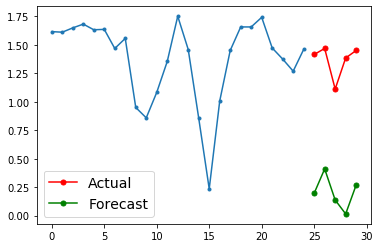

In [152]:
plot_multiple_distributed_forecasts(val_data, val_labels, model_CNN.predict(val_data))

## 3.5. Hybrid (recurrent + convolutional)

In [0]:
model_Hybrid_R_CNN = keras.models.Sequential(
    [
        keras.layers.Conv1D(
            filters=128, kernel_size=6, padding="same", input_shape=[None, 1]
        ),
        keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True)),
        keras.layers.Dense(prediction_length),
    ]
)

In [0]:
model_Hybrid_R_CNN.compile(loss=keras.losses.mse, optimizer=keras.optimizers.Adam(lr=1e-3))

In [137]:
model_Hybrid_R_CNN.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_63 (Conv1D)           (None, None, 128)         896       
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 256)         263168    
_________________________________________________________________
dense_7 (Dense)              (None, None, 5)           1285      
Total params: 265,349
Trainable params: 265,349
Non-trainable params: 0
_________________________________________________________________


In [138]:
model_Hybrid_R_CNN.fit(
    train_data,
    train_labels,
    validation_data=(val_data, val_labels),
    epochs=1000,
    verbose=2,
    callbacks=callbacks,
)

Train on 1 samples, validate on 1 samples
Epoch 1/1000
1/1 - 3s - loss: 0.9714 - val_loss: 0.6271
Epoch 2/1000
1/1 - 0s - loss: 0.6347 - val_loss: 0.3774
Epoch 3/1000
1/1 - 0s - loss: 0.3754 - val_loss: 0.1946
Epoch 4/1000
1/1 - 0s - loss: 0.1883 - val_loss: 0.0957
Epoch 5/1000
1/1 - 0s - loss: 0.0907 - val_loss: 0.0875
Epoch 6/1000
1/1 - 0s - loss: 0.0895 - val_loss: 0.1178
Epoch 7/1000
1/1 - 0s - loss: 0.1295 - val_loss: 0.1338
Epoch 8/1000
1/1 - 0s - loss: 0.1530 - val_loss: 0.1243
Epoch 9/1000
1/1 - 0s - loss: 0.1457 - val_loss: 0.0995
Epoch 10/1000
1/1 - 0s - loss: 0.1188 - val_loss: 0.0745
Epoch 11/1000
1/1 - 0s - loss: 0.0898 - val_loss: 0.0589
Epoch 12/1000
1/1 - 0s - loss: 0.0703 - val_loss: 0.0545
Epoch 13/1000
1/1 - 0s - loss: 0.0627 - val_loss: 0.0583
Epoch 14/1000
1/1 - 0s - loss: 0.0640 - val_loss: 0.0658
Epoch 15/1000
1/1 - 0s - loss: 0.0697 - val_loss: 0.0729
Epoch 16/1000
1/1 - 0s - loss: 0.0755 - val_loss: 0.0771
Epoch 17/1000
1/1 - 0s - loss: 0.0787 - val_loss: 0.077

In [153]:
result_model_Hybrid_R_CNN = model_Hybrid_R_CNN.evaluate(val_data, val_labels, verbose=2)

1/1 - 0s - loss: 0.0104


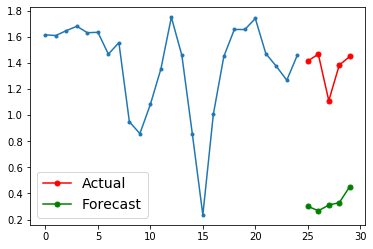

In [154]:
plot_multiple_distributed_forecasts(val_data, val_labels, model_Hybrid_R_CNN.predict(val_data))

**## 4. SUMMARY OF RESULTS ##**

In [0]:
summary_results = pd.DataFrame(columns = ["Val loss"])

In [0]:
summary_results.loc["result_model_RNN", 'Val loss'] = result_model_RNN
summary_results.loc["result_model_LSTM", 'Val loss'] = result_model_LSTM
summary_results.loc["result_model_LSTM_DO", 'Val loss'] = result_model_LSTM_DO
summary_results.loc["result_model_CNN", 'Val loss'] = result_model_CNN
summary_results.loc["result_model_Hybrid_R_CNN", 'Val loss'] = result_model_Hybrid_R_CNN

In [162]:
summary_results

,Val loss
result_model_RNN,0.100143
result_model_LSTM,0.100261
result_model_LSTM_DO,0.103323
result_model_CNN,0.0911369
result_model_Hybrid_R_CNN,0.0103986
